In [1]:
path = 'NN_sim7/'

hpath = 'drive/MyDrive/'
hpath + path

'drive/MyDrive/NN_sim7/'

In [2]:
import glob
import os
import re
# import h5py

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt

In [6]:
# Combined functions

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=100, 
                   verbose=0, mode='min',
                   restore_best_weights = True)


class CustomModelCheckpointCallback(ModelCheckpoint):

    def __init__(self, ignore_first=100, *args, **kwargs):
      super(CustomModelCheckpointCallback, self).__init__(*args, **kwargs)
      self.ignore_first = ignore_first

    def on_epoch_end(self, epoch, logs):
        if epoch+1> self.ignore_first:
            super().on_epoch_end(epoch, logs)


def create_folder(it = 1):
    # specify the path to the directory where you want to create a new folder
    # specify the name of the new folder
    folder_name = 'dat_' + str(it)

    # create the new folder under the specified directory
    new_folder_path = os.path.join(path, folder_name)
    os.makedirs(new_folder_path, exist_ok=True)
    
# create_folder(1)

## Setting:

Try parallel computing of the NN models and check if $\sigma_y^2$ from the bootstrap equal to EmpVar 

- error variance, which is set to 0.5^2.

Add conformal prediction intervals

In [7]:
def generate_data(n, it = 1,
                  p=50, err = 0.5,
                  a=1, b=2, ## X ~ Unif[a,b]
                  columns=[0, 5, 10, 15]):

    # Simulate data
    np.random.seed(it)
    
    # Generate 100 iid variables following uniform(a, b) distribution
    X = np.random.uniform(low=a, high=b, size=(n, p))

    X_selected = X[:, columns]

    y = 1/X_selected[:, 0] + X_selected[:, 1] + X_selected[:, 2]**2 + X_selected[:, 2]*X_selected[:, 3] + np.sin(X_selected[:, 3])

    # Add some noise to y
    y_obs = y + np.random.normal(0, err, size=y.shape)

    df = np.c_[y, y_obs, X]

    fname = path + 'df_' + str(it) + '.txt'
    np.savetxt(fname, df, delimiter='\t')
    
    return X, y, y_obs

In [13]:
n=400
ntest = 100
p = 20
a = 1
b = 2
err = 0.3

In [14]:
# Open the file and read its contents
with open(path + 'df_999.txt', 'r') as f:
    # Split the lines of the file into individual values
    values = [line.strip().split('\t') for line in f]

# Convert the values into a NumPy array
df = np.array(values, dtype=np.float)
df.shape

X_test = df[:, 2:]
y_test = df[:, 0]
y_test_obs = df[:, 1]
print(len(y_test))
X_test.shape

100


/scratch/zhef/11566888/ipykernel_3409767/881566868.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df = np.array(values, dtype=np.float)


(100, 20)

In [15]:
with open(path + 'df_0.txt', 'r') as f:
    # Split the lines of the file into individual values
    values = [line.strip().split('\t') for line in f]

# Convert the values into a NumPy array
df = np.array(values, dtype=np.float)
X = df[:, 2:]
y = df[:, 0]
y_obs = df[:, 1]

/scratch/zhef/11566888/ipykernel_3409767/3010079858.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df = np.array(values, dtype=np.float)


In [16]:
print(X.shape)

(400, 20)


In [17]:
import joblib
import time

import gc
gc.collect()



0

In [18]:
def one_split(X, y, X_test, y_test, # model,
              it = 1, b = 1, 
              th_val_loss = 0.3, 
              test_size=0.5,
              model_dense_layer_1_activation='relu', 
              model_dense_layer_2_activation='relu',
              early_stop_patience = 100, early_stop_min_delta = 0.001, 
              model_epochs=200, model_batch_size=32, model_loss='mse',
              model_optimizer='adam', 
              verbose=False,
              plot_res = False,
              del_weights = True):

    p = X.shape[1]
    n = len(y)
    ntest = len(y_test)

    # Split the data into training and testing sets
    indices = range(n)

    X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(X, y, indices,
                                                                                  test_size = test_size,
                                                                                  random_state = 1000*it+b) 


    es = EarlyStopping(monitor='val_loss', min_delta=early_stop_min_delta, 
                       patience=early_stop_patience, 
                       verbose=0, mode='min',
                       restore_best_weights = True)
    

    # Define and train the neural network
    model = Sequential()
    model.add(Dense(64, activation=model_dense_layer_1_activation, input_shape=(p,)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation=model_dense_layer_2_activation))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam')


    # loaded_model.compile(loss='mse', optimizer='adam')
    # model.fit(X_train, y_train, epochs=50, batch_size=32)


    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                        epochs=model_epochs, batch_size=32,
                        callbacks=[es],  verbose = verbose)
    
    val_loss = min(history.history['val_loss'])
    train_loss = min(history.history['loss'])
    train_epochs = len(history.history['val_loss'])

    y_pred = model.predict(X_test)
    y_val_pred = model.predict(X_val)
    # print(val_loss)
    # print(mean_squared_error(y_val, y_val_pred))

    y_vec = np.zeros(n+ntest)
    y_vec[indices_val] = y_val_pred.flatten()
    y_vec[-ntest:] = y_pred.flatten()
    
    if plot_res:
        # Plot the training and validation errors versus epochs
        plt.plot(history.history['loss'], label='Training Error')
        plt.plot(history.history['val_loss'], label='Validation Error')
        plt.xlabel('Epochs')
        plt.ylabel('Error')
        plt.legend()

        # Save the plot to a file
        plt.savefig('training_errs.png')
        plt.show()


    
    return train_loss, val_loss, y_vec, train_epochs

7/7 [==============================] - 0s 2ms/step


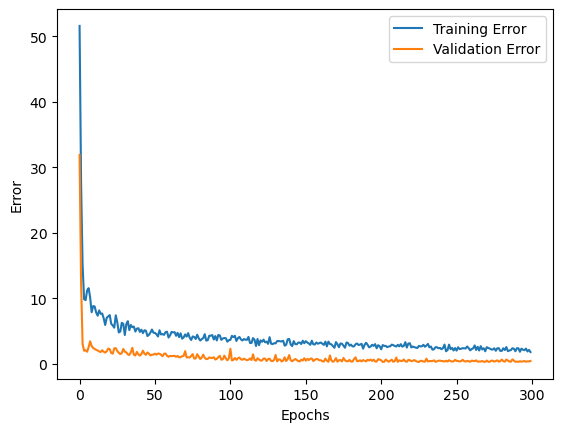

In [22]:
it = 0
train_loss, val_loss, y_vec, train_epochs = one_split(X, y_obs, X_test, y_test, 
                                                      it = it, b = 21,
                                                      test_size=0.5,
                                                      model_epochs=300,
                                                     verbose=False, plot_res=True)                        

1.7956881523132324
0.2856646776199341
300


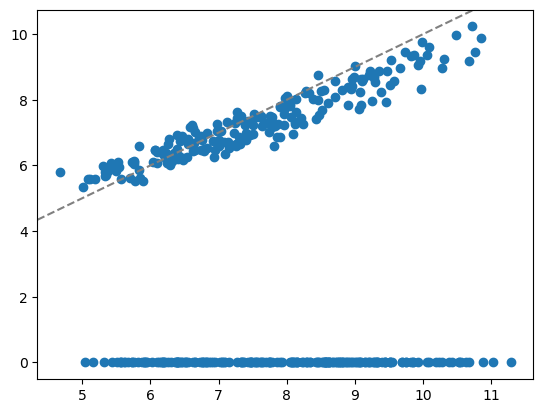

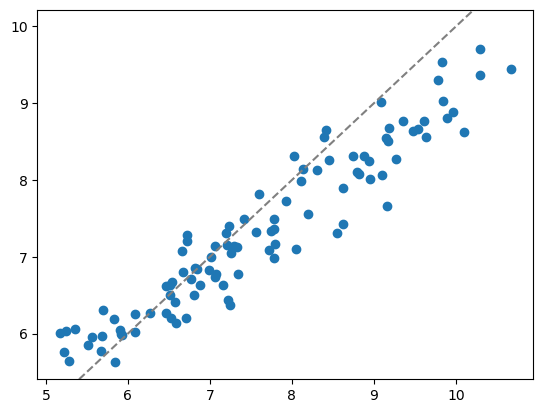

In [23]:
print(train_loss)
print(val_loss)
print(train_epochs)
# y_vec
n = len(y)
plt.scatter(y, y_vec[:n])
plt.axline((10, 10), slope=1, linestyle = '--', color='gray')
plt.show()

ntest = len(y_test)
plt.scatter(y_test, y_vec[-ntest:])
plt.axline((10, 10), slope=1, linestyle = '--', color='gray')
plt.show()

In [20]:
import multiprocessing

num_cpus = multiprocessing.cpu_count()
print("Number of CPUs:", num_cpus)

from joblib import Parallel, delayed, parallel_backend
num_cores = 10 # Number of CPU cores to use for parallel processing



Number of CPUs: 64


In [18]:
np.arange(2,11) * 100

array([ 200,  300,  400,  500,  600,  700,  800,  900, 1000])

In [21]:
import joblib
import time

import gc
gc.collect()


0

In [22]:
import multiprocessing
# X,y = generate_data(n=400, it = 10)
# it = 32
start_time = time.time()
# mem.clear(warn=False)
mem = joblib.Memory(location='cache', verbose=0)

@mem.cache
def run_one_split(X, y, X_test, y_test, it, b):
    return one_split(X, y, X_test, y_test, it, b,
                    test_size=0.5,
                     model_epochs=200)

In [24]:
b_vals = range(40)
# inputs = [(X, y, X_test, y_test, it, b) for b in b_vals]
it = 0
start_time = time.time()
# results = Parallel(n_jobs=num_cores, backend='loky')(delayed(run_one_split)(*i) for i in inputs)
with parallel_backend("loky"), Parallel(n_jobs= 20) as parallel:
    results = parallel(delayed(run_one_split)(X, y_obs, X_test, y_test, it, b) for b in b_vals)
    # terminate the processes
parallel._backend.terminate()
# parallel._backend.kill()

end_time = time.time()
elapsed_time = end_time - start_time

2023-06-09 23:06:18.000887: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 23:06:18.054670: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 23:06:18.078103: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09

7/7 [==============================] - 0s 923us/step


In [25]:
print(f"Elapsed time: {elapsed_time:.2f} seconds")
print(len(results))

train_losses = [result[0] for result in results]
val_losses = [result[1] for result in results]
y_vecs = [result[2] for result in results]
epochs = [result[3] for result in results]

print(len(y_vecs))
# print(val_losses)

Brep = len(val_losses)
y_mat = np.array(y_vecs)
print(y_mat.shape)

Elapsed time: 31.30 seconds
40
40
(40, 500)


In [26]:
[np.min(epochs), np.max(epochs)]

[200, 200]

In [27]:
fname = path + 'ypred_dat' + str(it) + '_Brep=' + str(Brep) + '.txt'
np.savetxt(fname, y_mat, delimiter='\t')

fname = path + 'val_loss_dat' + str(it) + '_Brep=' + str(Brep) + '.txt'
np.savetxt(fname, val_losses, delimiter='\t')

fname = path + 'train_loss_dat' + str(it) + '_Brep=' + str(Brep) + '.txt'
np.savetxt(fname, train_losses, delimiter='\t')

In [ ]:
# model, val_loss_final = save_model(X, y, it=it)

In [ ]:
val_loss_vec = []
val_loss_vec.append(12)
val_loss_vec.append(22)
val_loss_vec.append(32)
val_loss_vec

In [ ]:
nsim = 300
Brep = 100


# resall = np.zeros((nsim, n, 6))
# res_test = np.zeros((nsim, ntest, 6))

# early_stop_patience=200,

# y_fits_arr = np.empty((nsim, 200, n))
y_preds_arr = np.empty((nsim, Brep, n+ntest))
ntrain_epochs = np.empty((nsim, Brep))
val_losses = np.empty((nsim, Brep))

len(y_vec)

In [ ]:
# b_vals = range(Brep)
# num_cores = 6

for it in range(nsim):
    
    gc.collect()

    start_time = time.time()
    print(it)
    # create_folder(it)
    X, y, y_obs = generate_data(n, it)
    
    n_epochs = []
    val_loss_vec = []
    y_mat = np.zeros((0, n+ntest))
    for b in range(Brep):

        val_loss, y_vec, train_epochs = one_split(X, y_obs, X_test, y_test, it = it, b = b)                        
        print(train_epochs)
        # Separate val_loss and y_vec into two separate lists
        # val_losses = [result[0] for result in results]
        # y_vecs = [result[1] for result in results]

        val_loss_vec.append(val_loss)
        n_epochs.append(train_epochs)
        y_mat = np.vstack((y_mat, y_vec ) ) 

    # y_mat = np.array(y_vecs)
    print(f"y mat shape is {y_mat.shape}")
    
    y_preds_arr[it, :, :] = y_mat
    val_losses[it, :] = val_loss_vec
    ntrain_epochs[it, :] = n_epochs

    if it % 10 == 1:
        
        print(val_losses[it, :])
        print(np.mean(ntrain_epochs, axis=1))

        np.save(path+'_val_losses.npy', val_losses)
        np.save(path+'_ntrain_epochs.npy', ntrain_epochs)
        
        np.save(path+'_y_preds_arr.npy', y_preds_arr)



    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time:.2f} seconds")
    
    
    

In [ ]:
train_epochs
it

In [ ]:
len(val_loss_vec)
val_losses = np.array(val_loss_vec)  
val_losses.shape

In [ ]:
import multiprocess as mp
mp.cpu_count()
it

joblib/parallel.py:288: UserWarning: Persisting input arguments took 0.74s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)
